In [ ]:
import pandas as pd
import pyodbc
import statsmodels.api as sm
#from scipy import stats
#import numpy as np
import gc
import os
from woe5 import woe
from claudia import ks,gini
import pandas as pd
import pyodbc
import statsmodels.api as sm
#from scipy import stats
#import numpy as np

# Importación de la tabla en Chunks

In [ ]:
chunkTemp = []
queryTemp = []
query = pd.DataFrame()

for chunk in pd.read_csv('ori3.csv', header=0, chunksize=10000, iterator=True, low_memory=False,encoding='latin'):

    #REPLACING BLANK SPACES AT COLUMNS' NAMES FOR SQL OPTIMIZATION
    chunk = chunk.rename(columns = {c: c.replace(' ', '') for c in chunk.columns})

    #YOU CAN EITHER: 
    #1)BUFFER THE CHUNKS IN ORDER TO LOAD YOUR WHOLE DATASET 
    chunkTemp.append(chunk)

#!  NEVER DO pd.concat OR pd.DataFrame() INSIDE A LOOP
print("Database: CONCATENATING CHUNKS INTO A SINGLE DATAFRAME")
chunk = pd.concat(chunkTemp)
print("Database: LOADED")



In [ ]:
chunk.head()


In [ ]:
## Si usaramos SQl
#f="SELECT  * FROM bdrie.dbo.ori_base "
#sql_con = pyodbc.connect('driver={SQL Server};SERVER=OF00SRVBDH;Trusted_Connection=True;DATABASE=MIS1')
#base  = pd.read_sql(f, sql_con)

In [ ]:
chunk.columns

# Usamos filtros requeridos

In [ ]:
df = chunk[(chunk['prioridad_solicitud'] == 1) & (chunk['n_rcc'] >= 3) & (chunk['atr0_m'] <=8)]
len(df)

In [ ]:
df.id.unique()

In [ ]:
base = df[df['id']!= 2]
print(len(base))
print(base.id.unique())

# Division Entrenamiento y Test

In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(base,test_size=0.3)
print(len(train))
print(len(test))

# Variables 

In [ ]:
Variable Capacidad de pago contingente

          bad  bad_perc    breaks   good  good_perc index        iv      mean  \
labels                                                                          
0.0       901  0.040830  0.052934   6977   0.066830     0  0.012810  0.114369   
1.0      1004  0.045498  0.150451   5407   0.051791     1  0.000815  0.156606   
2.0     15506  0.702678       inf  75948   0.727471     2  0.000860  0.169550   
nan      4656  0.210994       NaN  16068   0.153908   nan  0.018009  0.224667   

          obs       per       woe                                    z  
labels                                                                  
0.0      7878  0.062293  0.492723  END_capacidad_pago_contingente_corr  
1.0      6411  0.050693  0.129556  END_capacidad_pago_contingente_corr  
2.0     91454  0.723145  0.034675  END_capacidad_pago_contingente_corr  
nan     20724  0.163869 -0.315473  END_capacidad_pago_contingente_corr  
True
0.1744882064095772


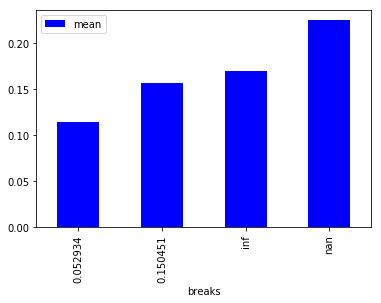

In [490]:
w=woe([float('-Inf'),0.052934,0.150451,float('Inf')])
w.fit(train['END_capacidad_pago_contingente_corr'],train['id'])
#w.optimize(max_nodes=5,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
print(sum(w.iv))
w.plot()


Variable Numero de Decrementos de Saldo

In [ ]:
w=woe()
w.fit(train['END_NUM_DECREM_SALDO_U24M'],train['id'])
w.optimize(max_nodes=4,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
w.plot()


# Calculo masivo de WOEs

In [ ]:
cuadro=w.massive(train,'id',deploy=True,train=train,test=test)
ivs=cuadro[0]

In [492]:
pd.options.display.max_rows = 999
View=ivs[ivs['Names'].str.contains("END_")]
View.sort_values(by='IV', ascending=False)


,Names,IV,Monotono,per_NA,depth
120,END_NUM_DECREM_SALDO_U24M,0.151103,True,0.000000,1
119,END_NUM_DECREM_SALDO_U12M,0.107889,True,0.000000,1
44,END_VAR_SALDO_TOTAL_U12M,0.092537,True,0.282595,2
93,END_DEUACT_MAXDEU_TOTAL_U24M,0.092245,True,0.099892,2
43,END_VAR_SALDO_TOTAL_U9M,0.088083,True,0.245653,2
28,END_DIF_ENT_TOTAL_U12M,0.083779,True,0.000000,1
67,END_NUM_INCREM_SALDO_TOTAL_U9M,0.070582,True,0.000000,2
92,END_DEUACT_MAXDEU_TOTAL_U12M,0.070125,True,0.117738,2
114,END_MAX_INCREM_SALDO_TOTAL_U6M,0.064823,True,0.359461,1
34,END_DIF_SALDO_TOTAL_U9M,0.064243,True,0.000000,1


# Guardando con pickle

In [379]:
import pickle
pickle.dump(cuadro, open('cuadro_ivs.pkl','wb'))
pickle.dump(train, open('ori3_train.pkl','wb'))
pickle.dump(test, open('ori3_test.pkl','wb'))

# Revisando variables Especificas

In [ ]:
cuadros=cuadro[1]

In [ ]:
##Chequeando tablas de Woes
#133 es capacidad de pago #134 es leveragetabla=cuadros[133] 
print(tabla)
print('     ')
print('El iv es: ',sum(tabla['iv']))
#print(sum(tabla['bad'])/(sum(tabla['bad'])+sum(tabla['good'])))

In [ ]:
#Reconstruyendo la variables
w=woe([float('-Inf'),0.052934,float('Inf')])
w.fit(train['END_capacidad_pago_contingente_corr'],train['id'])
#w.optimize(max_nodes=5,samples=round(0.05*len(train)))
print(w.stat)
print(w._checkMonotonic())
print(sum(w.stat['bad'])/(sum(w.stat['bad'])+sum(w.stat['good'])))
w.plot()
#train[str('END_capacidad_pago_contingente_corr'+'_binned')]=w.deploy(train)
#test[str('END_capacidad_pago_contingente_corr'+'_binned')]=w.deploy(test) 

In [ ]:
##Chequeando tablas de Woes
#133 es capacidad de pago
tabla=cuadros[134] 
print(tabla)
print('     ')
print('El iv es: ',sum(tabla['iv']))
#print(sum(tabla['bad'])/(sum(tabla['bad'])+sum(tabla['good'])))

# Filtrando solo columnas de interes

In [ ]:
#Renombrando
train = train.rename(columns={'capacidad_pago_contingente_corr_binned': 'END_capacidad_pago_contingente_corr_binned', 'capacidad_pago_contingente_corr': 'END_capacidad_pago_contingente_corr'})
test = test.rename(columns={'capacidad_pago_contingente_corr_binned': 'END_capacidad_pago_contingente_corr_binned', 'capacidad_pago_contingente_corr': 'END_capacidad_pago_contingente_corr'})
train = train.rename(columns={'leverage_contingente_corr_binned': 'END_leverage_contingente_corr_binned', 'leverage_contingente_corr': 'END_leverage_contingente_corr'})
test = test.rename(columns={'leverage_contingente_corr_binned': 'END_leverage_contingente_corr_binned', 'leverage_contingente_corr': 'END_leverage_contingente_corr'})

In [ ]:
#Quedandonos solo con las columnas de interes
filter_col = [col for col in train if col.startswith('END_')]
filter_col = [col for col in filter_col if col.endswith('_binned')]
x_train = train[filter_col]
x_test = test[filter_col]
y_train = train['id']
y_test = test['id']


# Funciones Necesarias

In [438]:
''' Backward Elimination'''

def backwardElimination(Y, X, sl,frame=False,test=False,dftest=None):
    numVars = len(X.columns)
    for i in range(0, numVars):
        X = sm.add_constant(X)
        regressor = sm.Logit(Y, X).fit()
        if frame:
            print(regressor.summary())
        maxVar = max(regressor.pvalues)#.astype(float)
        if maxVar > sl:
            for name in regressor.pvalues.index:
                if (regressor.pvalues[name].astype(float) == maxVar) and name!='const': #\
               # and name!='const':
                    X=X.drop([name],axis=1)
                    if test:
                        dftest=dftest.drop([name],axis=1)
    return X,dftest


''' Funcion para eliminar correlacion '''

def eliminate_corr(df):
    #Se pueden generar errores si una variables es no númerica
    #print(df.shape)
    corr=df.corr()
    #print(corr.shape)
    #Hacemos que por default todas las variables se incluyan (van con True)
    columns = np.full((corr.shape[0],), True, dtype=bool)
    
    #Vamos por cada fila
    for i in range(corr.shape[0]):
        #Vamos por cada columnas diferente a la variable (por eso el i+1)
        for j in range(i+1, corr.shape[0]):
            
            #Si la correlación es igual a 1 , hacemos que el campo sea False y por lo tanto no se incluya
            if abs(corr.iloc[i,j]) == 1:
                
                if columns[j]:
                    columns[j] = False
       
    selected_columns = df.columns[columns]
    return selected_columns


''' Funcion para escribir xlsx'''

def save_xls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,'sheet%s' % n)
        writer.save()



''' Funcion para eliminar correlaciones en función del IV '''

def eliminate_corr_iv(df,correla,ivs,analisis_iv=True):
    #Se pueden generar errores si una variables es no númerica
    #print(df.shape)
    corr=df.corr()
    #print(corr.shape)
    #Hacemos que por default todas las variables se incluyan (van con True)
    columns = np.full((corr.shape[0],), True, dtype=bool)
    
    #Vamos por cada fila
    for i in range(corr.shape[0]):
        #Vamos por cada columnas diferente a la variable (por eso el i+1)
        for j in range(i+1, corr.shape[0]):
            
        
           # print(i)
           # print(j)
           # print(corr.index.values)
           # print(corr.index.values[i][:-7])
           # print(corr.columns.values[j][:-7])
           # print(float(ivs[ivs['Names']==corr.index.values[i][:-7]]['IV']))
           # print(float(ivs[ivs['Names']==corr.columns.values[j][:-7]]['IV']))
            
   
            
#            print((float(ivs[ivs['Names']==corr.columns.values[j][:-7]]['IV']) < float(ivs[ivs['Names']==corr.columns.values[i][:-7]]['IV'])))
#            if abs(corr.iloc[i,j]) > 0.5:
#                True
#            else:
#                False
            
#           break
#        break
        
            #Si la correlación es igual a un corr , hacemos que el campo sea False y por lo tanto no se incluya
            #Solo s excluye si el iv de la variable en la columna es menor a lde la fila 
            if abs(corr.iloc[i,j]) > correla:
                if analisis_iv:
                    if columns[j] and (float(ivs[ivs['Names']==corr.columns.values[j][:-7]]['IV']) > float(ivs[ivs['Names']==corr.columns.values[i][:-7]]['IV'])) :
                        if columns[i]:
                            columns[i] = False 
                    elif columns[j] and (float(ivs[ivs['Names']==corr.columns.values[j][:-7]]['IV']) < float(ivs[ivs['Names']==corr.columns.values[i][:-7]]['IV'])) : 
                        if columns[j]:
                            columns[j] = False 
                    else:
                        pass
                else:
                    if columns[j]:
                        columns[j] = False 

            #break
       
    selected_columns = df.columns[columns]
    return selected_columns        


In [ ]:
cor=x_train.corr()

In [ ]:
#print(cor.columns.values[0][:-7])
#print(cor.index.values[1][:-7])
float(ivs[ivs['Names']==cor.columns.values[0][:-7]]['IV'])

In [ ]:
#####Corrigiendo un problema con nombres #####
#ivs2=ivs.copy()
#ivs2[ivs2['Names']=='capacidad_pago_contingente_corr']['Names']
#ivs2.at[133,'Names']='END_capacidad_pago_contingente_corr'
#ivs2[ivs2['Names']=='END_leverage_contingente_corr']
#ivs2.at[134,'Names']='END_leverage_contingente_corr'

# Revisando Correlación

In [504]:
#Creando la tabla final
import numpy as np
x_trainh=x_train.copy()
x_train is x_trainh

False

In [505]:
#Evitando que la matriz sea singular
final_columns = eliminate_corr(x_trainh)

In [506]:
x_trainh=x_trainh[final_columns]
x_trainh.head()

,END_PROM_PU_TC_U6M_binned,END_PROM_PU_TC_U9M_binned,END_PROM_PU_TC_U12M_binned,END_MAX_PU_TC_U3M_binned,END_MAX_PU_TC_U6M_binned,END_MAX_PU_TC_U9M_binned,END_ULTIMO_SOW_binned,END_POR_UTI_LINEA_UM_binned,END_POR_UTI_LINEA_3M_binned,END_POR_UTI_LINEA_6M_binned,END_DIF_ENT_TOTAL_U6M_binned,END_DIF_ENT_TOTAL_U9M_binned,END_DIF_ENT_TOTAL_U12M_binned,END_DIF_ENT_MICRO_U9M_binned,END_DIF_ENT_MICRO_U12M_binned,END_DIF_SALDO_TOTAL_UM_binned,END_DIF_SALDO_TOTAL_U3M_binned,END_DIF_SALDO_TOTAL_U6M_binned,END_DIF_SALDO_TOTAL_U9M_binned,END_DIF_SALDO_TOTAL_U12M_binned,END_DIF_SALDO_MICRO_U3M_binned,END_DIF_SALDO_MICRO_U6M_binned,END_DIF_SALDO_MICRO_U9M_binned,END_DIF_SALDO_MICRO_U12M_binned,END_VAR_SALDO_TOTAL_UM_binned,END_VAR_SALDO_TOTAL_U3M_binned,END_VAR_SALDO_TOTAL_U6M_binned,END_VAR_SALDO_TOTAL_U9M_binned,END_VAR_SALDO_TOTAL_U12M_binned,END_VAR_SALDO_MICRO_U3M_binned,END_VAR_SALDO_MICRO_U6M_binned,END_VAR_SALDO_MICRO_U9M_binned,END_VAR_SALDO_MICRO_U12M_binned,END_ENT_SALDO_TOTAL_UM_binned,END_DIF_PORCEN_UTIL_LINEA_U12M_binned,END_NUM_INCREM_SALDO_TOTAL_U3M_binned,END_NUM_INCREM_SALDO_TOTAL_U6M_binned,END_NUM_INCREM_SALDO_TOTAL_U9M_binned,END_NUM_INCREM_SALDO_TOTAL_U12M_binned,END_NUM_INCREM_SALDO_MICRO_U3M_binned,END_NUM_INCREM_SALDO_MICRO_U6M_binned,END_NUM_INCREM_SALDO_MICRO_U9M_binned,END_NUM_INCREM_SALDO_MICRO_U12M_binned,END_MAXSALDOTC_PROMLINEATC_U3M_binned,END_MAXSALDOTC_PROMLINEATC_U6M_binned,END_MAXSALDOTC_PROMLINEATC_U9M_binned,END_MAXSALDOTC_PROMLINEATC_U12M_binned,END_DEUACT_MAXDEU_TOTAL_U6M_binned,END_DEUACT_MAXDEU_TOTAL_U12M_binned,END_DEUACT_MAXDEU_TOTAL_U24M_binned,END_DEUACT_MAXDEU_MICRO_U6M_binned,END_DEUACT_MAXDEU_MICRO_U12M_binned,END_DEUACT_MAXDEU_MICRO_U24M_binned,END_SALDOMAXCOMP_SALDOMAX_TOTAL_U24M_binned,END_MAX_INCREM_SALDO_TOTAL_U6M_binned,END_MAX_INCREM_SALDO_TOTAL_U12M_binned,END_MAX_INCREM_SALDO_MICRO_U6M_binned,END_MAX_INCREM_SALDO_MICRO_U12M_binned,END_NUM_DECREM_SALDO_U6M_binned,END_NUM_DECREM_SALDO_U12M_binned,END_NUM_DECREM_SALDO_U24M_binned,END_capacidad_pago_contingente_corr_binned,END_leverage_contingente_corr_binned
258774,0.039452,0.041593,0.037886,0.037766,0.041943,0.038591,-0.124996,-0.037748,-0.047961,-0.057920,-0.333947,-0.349683,-0.702717,-0.288467,-0.272686,-0.363140,-0.306090,-0.241930,-0.255591,-0.223899,-0.299841,-0.205635,-0.222087,-0.180666,-0.432754,-0.338139,-0.230879,-0.233809,-0.197384,-0.337566,-0.103193,-0.195077,-0.010108,-0.293528,-0.060337,-0.445109,-0.460123,-0.539738,-0.461471,-0.246138,-0.360033,-0.412148,-0.411814,-0.037390,-0.040136,-0.043720,-0.049432,-0.433087,-0.537618,-0.618821,-0.401850,-0.499852,-0.574968,-0.099458,0.223246,0.390231,0.092719,0.419589,-0.19173,-0.246049,-0.355376,0.040710,0.046122
155521,0.039452,0.041593,0.037886,0.037766,0.041943,0.038591,0.232823,-0.037748,-0.047961,-0.057920,-0.333947,-0.349683,-0.226361,-0.288467,-0.272686,0.070041,-0.306090,-0.241930,-0.255591,-0.223899,-0.299841,-0.205635,-0.222087,-0.180666,0.066020,0.007558,-0.122297,-0.224155,-0.273320,-0.024882,-0.081439,-0.140606,-0.176111,0.120522,-0.060337,-0.193167,0.048275,0.150865,0.221876,-0.246138,0.018722,0.136594,0.103592,-0.037390,-0.040136,-0.043720,-0.049432,-0.039960,-0.168064,-0.236009,-0.054195,-0.143401,-0.195358,0.220320,-0.283255,-0.276026,-0.393363,-0.396402,-0.19173,-0.246049,-0.355376,0.040710,0.046122
111421,0.039452,0.041593,0.037886,0.037766,0.041943,0.038591,-0.124996,-0.037748,-0.047961,-0.057920,0.093924,-0.349683,-0.226361,-0.288467,-0.272686,0.070041,0.103371,-0.241930,-0.255591,-0.223899,0.071429,-0.205635,-0.222087,-0.180666,0.066020,0.059451,-0.230879,-0.224155,-0.273320,0.102109,-0.103193,-0.140606,-0.176111,0.120522,-0.060337,0.180475,0.048275,-0.178878,0.086179,0.118512,0.018722,-0.138300,0.103592,-0.037390,-0.040136,-0.043720,-0.049432,0.076418,0.102239,-0.006991,0.149562,0.125618,0.086556,-0.099458,-0.283255,-0.276026,-0.393363,-0.396402,-0.19173,-0.246049,-0.355376,-0.315473,-0.315473
17966,0.039452,0.041593,0.037886,0.037766,0.041943,0.038591,-0.1

Ninguna variables tenia una correalción de 1

In [439]:
#Evitando que la matriz tengan variables que se correlacionan mucho entre ellas
final_columns = eliminate_corr_iv(x_train,0.60,ivs2,analisis_iv=False)
print(len(final_columns))
print(final_columns)


11
Index(['END_PROM_PU_TC_U6M_binned', 'END_ULTIMO_SOW_binned',
       'END_POR_UTI_LINEA_UM_binned', 'END_DIF_ENT_TOTAL_U6M_binned',
       'END_DIF_SALDO_TOTAL_UM_binned', 'END_DIF_SALDO_TOTAL_U6M_binned',
       'END_ENT_SALDO_TOTAL_UM_binned',
       'END_DIF_PORCEN_UTIL_LINEA_U12M_binned',
       'END_MAX_INCREM_SALDO_TOTAL_U6M_binned',
       'END_NUM_DECREM_SALDO_U6M_binned',
       'END_capacidad_pago_contingente_corr_binned'],
      dtype='object')


In [507]:
#Evitando que la matriz tengan variables que se correlacionan mucho entre ellas
final_columns = eliminate_corr_iv(x_train,0.60,ivs2,analisis_iv=True) #Notese que se usa iv2 en vez de ivs
print(len(final_columns))
print(final_columns)
x_trainh=x_train.copy()
x_trainh=x_trainh[final_columns]

13
Index(['END_PROM_PU_TC_U12M_binned', 'END_ULTIMO_SOW_binned',
       'END_DIF_ENT_TOTAL_U12M_binned', 'END_VAR_SALDO_TOTAL_U12M_binned',
       'END_ENT_SALDO_TOTAL_UM_binned',
       'END_DIF_PORCEN_UTIL_LINEA_U12M_binned',
       'END_NUM_INCREM_SALDO_TOTAL_U9M_binned',
       'END_MAXSALDOTC_PROMLINEATC_U12M_binned',
       'END_DEUACT_MAXDEU_TOTAL_U24M_binned',
       'END_MAX_INCREM_SALDO_TOTAL_U6M_binned',
       'END_MAX_INCREM_SALDO_MICRO_U12M_binned',
       'END_NUM_DECREM_SALDO_U24M_binned',
       'END_capacidad_pago_contingente_corr_binned'],
      dtype='object')


In [512]:
x_testh=x_test.copy()
x_testh=x_testh[final_columns]
x_trainh.drop(['END_capacidad_pago_contingente_corr_binned','END_MAX_INCREM_SALDO_TOTAL_U6M_binned','END_MAX_INCREM_SALDO_MICRO_U12M_binned'],axis=1,inplace=True)
x_testh.drop(['END_capacidad_pago_contingente_corr_binned','END_MAX_INCREM_SALDO_TOTAL_U6M_binned','END_MAX_INCREM_SALDO_MICRO_U12M_binned'],axis=1,inplace=True)
print(x_trainh.columns)
print(x_testh.columns)

Index(['END_PROM_PU_TC_U12M_binned', 'END_ULTIMO_SOW_binned',
       'END_DIF_ENT_TOTAL_U12M_binned', 'END_VAR_SALDO_TOTAL_U12M_binned',
       'END_ENT_SALDO_TOTAL_UM_binned',
       'END_DIF_PORCEN_UTIL_LINEA_U12M_binned',
       'END_NUM_INCREM_SALDO_TOTAL_U9M_binned',
       'END_MAXSALDOTC_PROMLINEATC_U12M_binned',
       'END_DEUACT_MAXDEU_TOTAL_U24M_binned',
       'END_NUM_DECREM_SALDO_U24M_binned'],
      dtype='object')
Index(['END_PROM_PU_TC_U12M_binned', 'END_ULTIMO_SOW_binned',
       'END_DIF_ENT_TOTAL_U12M_binned', 'END_VAR_SALDO_TOTAL_U12M_binned',
       'END_ENT_SALDO_TOTAL_UM_binned',
       'END_DIF_PORCEN_UTIL_LINEA_U12M_binned',
       'END_NUM_INCREM_SALDO_TOTAL_U9M_binned',
       'END_MAXSALDOTC_PROMLINEATC_U12M_binned',
       'END_DEUACT_MAXDEU_TOTAL_U24M_binned',
       'END_NUM_DECREM_SALDO_U24M_binned'],
      dtype='object')


In [519]:
x_trainh.corr()

,const,END_PROM_PU_TC_U12M_binned,END_ULTIMO_SOW_binned,END_DIF_ENT_TOTAL_U12M_binned,END_VAR_SALDO_TOTAL_U12M_binned,END_ENT_SALDO_TOTAL_UM_binned,END_DIF_PORCEN_UTIL_LINEA_U12M_binned,END_NUM_INCREM_SALDO_TOTAL_U9M_binned,END_MAXSALDOTC_PROMLINEATC_U12M_binned,END_DEUACT_MAXDEU_TOTAL_U24M_binned,END_NUM_DECREM_SALDO_U24M_binned
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
END_PROM_PU_TC_U12M_binned,NaN,1.000000,0.163329,0.015046,-0.063415,0.218820,-0.181711,0.153377,0.359474,0.041835,-0.023938
END_ULTIMO_SOW_binned,NaN,0.163329,1.000000,0.185075,-0.049966,0.523908,-0.146050,0.350491,0.010388,0.236147,-0.165280
END_DIF_ENT_TOTAL_U12M_binned,NaN,0.015046,0.185075,1.000000,0.401686,0.377013,0.078205,0.297260,0.025883,0.259661,0.191660
END_VAR_SALDO_TOTAL_U12M_binned,NaN,-0.063415,-0.049966,0.401686,1.000000,-0.039170,0.167940,0.132499,0.072656,0.509182,0.449408
END_ENT_SALDO_TOTAL_UM_binned,NaN,0.218820,0.523908,0.377013,-0.039170,1.000000,-0.204986,0.504636,0.030855,0.275812,-0.158214
END_DIF_PORCEN_UTIL_LINEA_U12M_binned,NaN,-0.181711,-0.146050,0.078205,0.167940,-0.204986,1.000000,-0.109081,0.387522,0.046319,0.146586
END_NUM_INCREM_SALDO_TOTAL_U9M_binned,NaN,0.153377,0.350491,0.297260,0.132499,0.504636,-0.109081,1.000000,0.057174,0.406677,0.078525
END_MAXSALDOTC_PROMLINEATC_U12M_binned,NaN,0.359474,0.010388,0.025883,0.072656,0.030855,0.387522,0.057174,1.000000,0.064221,0.119363
END_DEUACT_MAXDEU_TOTAL_U24M_binned,NaN,0.041835,0.236147,0.259661,0.509182,0.275812,0.046319,0.406677,0.064221,1.000000,0.174499


# Modelamiento

In [ ]:
x_train.corr()

In [ ]:
import statsmodels.api as sm

In [513]:
#Añadiendo Constante
#x_trainh = x_train.copy()
x_trainh = sm.add_constant(x_trainh)
x_testh = sm.add_constant(x_testh)

In [369]:
#Definiendo Respuesta
y_trainh = 1 - y_train
y_testh = 1 - y_test

In [370]:
#Nivel de p value
SL=0.01

In [ ]:
#Backward Elimination
x_trainh,x_testh = backwardElimination(y_trainh,x_trainh,\
                                           SL,test=True,\
                                       dftest=x_testh,frame=True)


In [515]:
#Modelo Final 1 
est = sm.Logit(y_trainh,x_trainh)
res = est.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.440629
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     id   No. Observations:               126467
Model:                          Logit   Df Residuals:                   126456
Method:                           MLE   Df Model:                           10
Date:                Thu, 11 Jul 2019   Pseudo R-squ.:                 0.04818
Time:                        09:42:42   Log-Likelihood:                -55725.
converged:                       True   LL-Null:                       -58546.
                                        LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      1.5572   

# Chequeando que las variables tengan sentido

In [459]:
ivs[ivs['Names']=='END_PROM_PU_TC_U12M']
cuadros[13] 

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0,20296,0.919744,0.583611,99729,0.955259,0,0.001346,0.169098,120025,0.949062,0.037886,END_PROM_PU_TC_U12M
1,1771,0.080256,inf,4671,0.044741,1,0.020752,0.274915,6442,0.050938,-0.584318,END_PROM_PU_TC_U12M


Mejora en IV por agregar la categoría NA

In [593]:
ivs[ivs['Names']=='END_ULTIMO_SOW']
print(cuadros[17])
sum(cuadros[17].iv)

          bad  bad_perc    breaks   good  good_perc index        iv      mean  \
labels                                                                          
0.0     11550  0.523406  0.401714  48223   0.461906     0  0.007687  0.193231   
1.0      2338  0.105950  0.835406  10290   0.098563     1  0.000534  0.185144   
2.0      4290  0.194408       inf  25617   0.245374     2  0.011866  0.143445   
nan      3889  0.176236       NaN  20270   0.194157   nan  0.001736  0.160975   

          obs       per       woe               z  
labels                                             
0.0     59773  0.472637 -0.124996  END_ULTIMO_SOW  
1.0     12628  0.099852 -0.072270  END_ULTIMO_SOW  
2.0     29907  0.236481  0.232823  END_ULTIMO_SOW  
nan     24159  0.191030  0.096844  END_ULTIMO_SOW  


0.021822578967101856

Agregar saldo compartamos (crear una nueva variable)
Juntar el campo 0 y el campo 1 en esta variable                       

In [465]:
ivs[ivs['Names']=='END_DIF_ENT_TOTAL_U12M']
cuadros[28] 

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0,2958,0.134046,-0.500000,19148,0.183410,0,0.015477,0.133810,22106,0.174797,0.313539,END_DIF_ENT_TOTAL_U12M
1,9248,0.419087,0.500000,51651,0.494741,1,0.012555,0.151858,60899,0.481541,0.165956,END_DIF_ENT_TOTAL_U12M
2,7342,0.332714,1.500000,27699,0.265316,2,0.015256,0.209526,35041,0.277076,-0.226361,END_DIF_ENT_TOTAL_U12M
3,2519,0.114152,inf,5902,0.056533,3,0.040490,0.299133,8421,0.066587,-0.702717,END_DIF_ENT_TOTAL_U12M


In [467]:
ivs[ivs['Names']=='END_VAR_SALDO_TOTAL_U12M']
cuadros[44] 

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0.0,1320,0.059818,0.239488,11386,0.109061,0,0.029576,0.103888,12706,0.100469,0.600606,END_VAR_SALDO_TOTAL_U12M
1.0,2184,0.098971,0.736145,16247,0.155623,1,0.025641,0.118496,18431,0.145738,0.452604,END_VAR_SALDO_TOTAL_U12M
2.0,1770,0.080210,1.007493,10680,0.102299,2,0.005373,0.142169,12450,0.098445,0.243247,END_VAR_SALDO_TOTAL_U12M
3.0,3456,0.156614,1.697618,16498,0.158027,3,0.000013,0.173198,19954,0.157780,0.008981,END_VAR_SALDO_TOTAL_U12M
4.0,5567,0.252277,inf,21620,0.207088,4,0.008920,0.204767,27187,0.214973,-0.197384,END_VAR_SALDO_TOTAL_U12M
nan,7770,0.352109,NaN,27969,0.267902,nan,0.023015,0.217410,35739,0.282595,-0.273320,END_VAR_SALDO_TOTAL_U12M


In [469]:
ivs[ivs['Names']=='END_ENT_SALDO_TOTAL_UM']
cuadros[56] 

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0,11198,0.507455,1.500000,59764,0.572452,0,0.007834,0.157803,70962,0.561111,0.120522,END_ENT_SALDO_TOTAL_UM
1,5833,0.264331,2.500000,26871,0.257385,1,0.000185,0.178357,32704,0.258597,-0.026630,END_ENT_SALDO_TOTAL_UM
2,5036,0.228214,inf,17765,0.170163,2,0.017040,0.220868,22801,0.180292,-0.293528,END_ENT_SALDO_TOTAL_UM


In [471]:
#END_DIF_PORCEN_UTIL_LINEA_U12M
ivs[ivs['Names']=='END_DIF_PORCEN_UTIL_LINEA_U12M']
cuadros[64] 

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0.0,2346,0.106313,0.031072,16201,0.155182,0,1.848313e-02,0.126489,18547,0.146655,0.378215,END_DIF_PORCEN_UTIL_LINEA_U12M
1.0,1317,0.059682,inf,6227,0.059646,1,2.206587e-08,0.174576,7544,0.059652,-0.000608,END_DIF_PORCEN_UTIL_LINEA_U12M
nan,18404,0.834006,NaN,81972,0.785172,nan,2.946429e-03,0.183351,100376,0.793693,-0.060337,END_DIF_PORCEN_UTIL_LINEA_U12M


In [473]:
ivs[ivs['Names']=='END_NUM_INCREM_SALDO_TOTAL_U9M']
cuadros[67]
#END_NUM_INCREM_SALDO_TOTAL_U9M

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0,4810,0.217973,0.500000,30653,0.293611,0,0.022532,0.135634,35463,0.280413,0.297887,END_NUM_INCREM_SALDO_TOTAL_U9M
1,6212,0.281506,1.500000,34175,0.327347,1,0.006916,0.153812,40387,0.319348,0.150865,END_NUM_INCREM_SALDO_TOTAL_U9M
2,5791,0.262428,2.500000,22910,0.219444,2,0.007689,0.201770,28701,0.226945,-0.178878,END_NUM_INCREM_SALDO_TOTAL_U9M
3,3314,0.150179,3.500000,11312,0.108352,3,0.013654,0.226583,14626,0.115651,-0.326438,END_NUM_INCREM_SALDO_TOTAL_U9M
4,1940,0.087914,inf,5350,0.051245,4,0.019792,0.266118,7290,0.057643,-0.539738,END_NUM_INCREM_SALDO_TOTAL_U9M


In [475]:
ivs[ivs['Names']=='END_MAXSALDOTC_PROMLINEATC_U12M']
cuadros[76]
#END_MAXSALDOTC_PROMLINEATC_U12M

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0.0,1485,0.067295,0.194839,13420,0.128544,0,0.039639,0.099631,14905,0.117857,0.647185,END_MAXSALDOTC_PROMLINEATC_U12M
1.0,1172,0.053111,0.617195,7117,0.068170,1,0.003759,0.141392,8289,0.065543,0.249628,END_MAXSALDOTC_PROMLINEATC_U12M
2.0,1457,0.066026,0.959697,6030,0.057759,2,0.001106,0.194604,7487,0.059201,-0.133779,END_MAXSALDOTC_PROMLINEATC_U12M
3.0,1730,0.078398,inf,4783,0.045814,3,0.017504,0.265623,6513,0.051500,-0.537200,END_MAXSALDOTC_PROMLINEATC_U12M
nan,16223,0.735170,NaN,73050,0.699713,nan,0.001753,0.181723,89273,0.705900,-0.049432,END_MAXSALDOTC_PROMLINEATC_U12M


In [477]:
ivs[ivs['Names']=='END_DEUACT_MAXDEU_TOTAL_U24M']
cuadros[93]

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0.0,4665,0.211402,0.398806,32879,0.314933,0,0.041268,0.124254,37544,0.296868,0.398600,END_DEUACT_MAXDEU_TOTAL_U24M
1.0,3550,0.160874,0.629422,19248,0.184368,1,0.003203,0.155715,22798,0.180268,0.136313,END_DEUACT_MAXDEU_TOTAL_U24M
2.0,2355,0.106720,0.735910,11064,0.105977,2,0.000005,0.175497,13419,0.106107,-0.006991,END_DEUACT_MAXDEU_TOTAL_U24M
3.0,6644,0.301083,0.987677,24825,0.237787,3,0.014938,0.211128,31469,0.248832,-0.236009,END_DEUACT_MAXDEU_TOTAL_U24M
4.0,2425,0.109893,inf,6179,0.059186,4,0.031378,0.281846,8604,0.068034,-0.618821,END_DEUACT_MAXDEU_TOTAL_U24M
nan,2428,0.110029,NaN,10205,0.097749,nan,0.001453,0.192195,12633,0.099892,-0.118336,END_DEUACT_MAXDEU_TOTAL_U24M


In [479]:
ivs[ivs['Names']=='END_MAX_INCREM_SALDO_TOTAL_U6M']
cuadros[114]

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0.0,10542,0.477727,3673.385010,37572,0.359885,0,0.033379,0.219105,48114,0.380447,-0.283255,END_MAX_INCREM_SALDO_TOTAL_U6M
1.0,2491,0.112883,7668.500000,11498,0.110134,1,0.000068,0.178068,13989,0.110614,-0.024658,END_MAX_INCREM_SALDO_TOTAL_U6M
2.0,2734,0.123895,inf,16170,0.154885,2,0.006918,0.144625,18904,0.149478,0.223246,END_MAX_INCREM_SALDO_TOTAL_U6M
nan,6300,0.285494,NaN,39160,0.375096,nan,0.024458,0.138583,45460,0.359461,0.272960,END_MAX_INCREM_SALDO_TOTAL_U6M


In [481]:
ivs[ivs['Names']=='END_MAX_INCREM_SALDO_MICRO_U12M']
cuadros[117]

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0.0,4695,0.212761,1.662775e+03,14943,0.143132,0,0.027601,0.239077,19638,0.155282,-0.396402,END_MAX_INCREM_SALDO_MICRO_U12M
1.0,4044,0.183260,3.678125e+03,16555,0.158573,1,0.003572,0.196320,20599,0.162880,-0.144693,END_MAX_INCREM_SALDO_MICRO_U12M
2.0,2753,0.124756,7.377085e+03,14031,0.134397,2,0.000718,0.164025,16784,0.132714,0.074432,END_MAX_INCREM_SALDO_MICRO_U12M
3.0,2130,0.096524,1.636906e+04,12197,0.116830,3,0.003877,0.148670,14327,0.113286,0.190922,END_MAX_INCREM_SALDO_MICRO_U12M
4.0,1767,0.080074,inf,12718,0.121820,4,0.017516,0.121988,14485,0.114536,0.419589,END_MAX_INCREM_SALDO_MICRO_U12M
nan,6678,0.302624,NaN,33956,0.325249,nan,0.001631,0.164345,40634,0.321301,0.072101,END_MAX_INCREM_SALDO_MICRO_U12M


In [483]:
ivs[ivs['Names']=='END_NUM_DECREM_SALDO_U24M']
cuadros[120]

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0,10907,0.494267,12.500000,36168,0.346437,0,0.052536,0.231694,47075,0.372231,-0.355376,END_NUM_DECREM_SALDO_U24M
1,4589,0.207958,16.500000,19920,0.190805,1,0.001477,0.187237,24509,0.193798,-0.086084,END_NUM_DECREM_SALDO_U24M
2,5623,0.254815,20.500000,36590,0.350479,2,0.030494,0.133205,42213,0.333787,0.318763,END_NUM_DECREM_SALDO_U24M
3,948,0.042960,inf,11722,0.112280,3,0.066597,0.074822,12670,0.100184,0.960722,END_NUM_DECREM_SALDO_U24M


In [486]:
ivs[ivs['Names']=='capacidad_pago_contingente_corr']
cuadros[133]


,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0.0,901,0.040830,0.052934,6977,0.066830,0,0.012810,0.114369,7878,0.062293,0.492723,capacidad_pago_contingente_corr
1.0,16510,0.748176,inf,81355,0.779262,1,0.001266,0.168702,97865,0.773838,0.040710,capacidad_pago_contingente_corr
nan,4656,0.210994,NaN,16068,0.153908,nan,0.018009,0.224667,20724,0.163869,-0.315473,capacidad_pago_contingente_corr


# KS Gini

In [516]:
print(x_trainh.shape)
print(x_testh.shape)

(126467, 11)
(54201, 11)


In [517]:
y_pred_test=res.predict(x_testh)
y_pred_train=res.predict(x_trainh)

-----------------------------------------------Train--------------------------------------


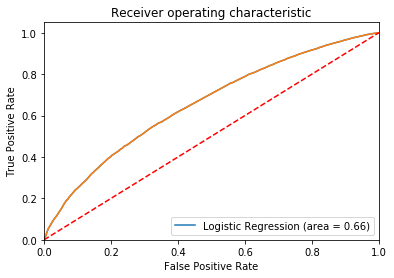

(0.655152425250721, 0.3103048505014421)
Ks_2sampResult(statistic=0.22236293310497962, pvalue=0.0)
-----------------------------------------------Test---------------------------------------


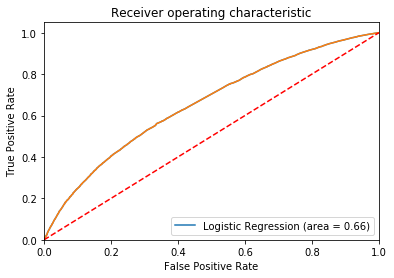

(0.6551489060434409, 0.3102978120868818)
Ks_2sampResult(statistic=0.22506536263376647, pvalue=0.0)


In [518]:
print('-----------------------------------------------Train--------------------------------------')
print(gini(y_trainh,y_pred_train,plot=True)) # Train
print(ks(y_trainh,y_pred_train)) #Train
print('-----------------------------------------------Test---------------------------------------')
print(gini(y_testh,y_pred_test,plot=True)) # Test
print(ks(y_testh,y_pred_test)) #Test

In [592]:
x_trainh.columns

Index(['const', 'END_PROM_PU_TC_U12M_binned', 'END_ULTIMO_SOW_binned',
       'END_DIF_ENT_TOTAL_U12M_binned', 'END_VAR_SALDO_TOTAL_U12M_binned',
       'END_ENT_SALDO_TOTAL_UM_binned',
       'END_DIF_PORCEN_UTIL_LINEA_U12M_binned',
       'END_NUM_INCREM_SALDO_TOTAL_U9M_binned',
       'END_MAXSALDOTC_PROMLINEATC_U12M_binned',
       'END_DEUACT_MAXDEU_TOTAL_U24M_binned',
       'END_NUM_DECREM_SALDO_U24M_binned'],
      dtype='object')

# Deep Learning

In [493]:
from keras.models import Sequential
from keras.layers import Dense, Activation

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [553]:
#################################################Balancing Data#########################################
dff=pd.concat([x_train,y_train],axis=1)


from sklearn.utils import resample

# Separate majority and minority classes
df_majority = dff[dff.id==0]
df_minority = dff[dff.id==1]

#len(df_majority)
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.id.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64


1    104400
0    104400
Name: id, dtype: int64

In [549]:
y_traind=df_upsampled['id']
x_traind=df_upsampled.iloc[:,0 : df_upsampled.shape[1]-1]
x_traind.columns

Index(['END_PROM_PU_TC_U6M_binned', 'END_PROM_PU_TC_U9M_binned',
       'END_PROM_PU_TC_U12M_binned', 'END_MAX_PU_TC_U3M_binned',
       'END_MAX_PU_TC_U6M_binned', 'END_MAX_PU_TC_U9M_binned',
       'END_ULTIMO_SOW_binned', 'END_POR_UTI_LINEA_UM_binned',
       'END_POR_UTI_LINEA_3M_binned', 'END_POR_UTI_LINEA_6M_binned',
       'END_DIF_ENT_TOTAL_U6M_binned', 'END_DIF_ENT_TOTAL_U9M_binned',
       'END_DIF_ENT_TOTAL_U12M_binned', 'END_DIF_ENT_MICRO_U9M_binned',
       'END_DIF_ENT_MICRO_U12M_binned', 'END_DIF_SALDO_TOTAL_UM_binned',
       'END_DIF_SALDO_TOTAL_U3M_binned', 'END_DIF_SALDO_TOTAL_U6M_binned',
       'END_DIF_SALDO_TOTAL_U9M_binned', 'END_DIF_SALDO_TOTAL_U12M_binned',
       'END_DIF_SALDO_MICRO_U3M_binned', 'END_DIF_SALDO_MICRO_U6M_binned',
       'END_DIF_SALDO_MICRO_U9M_binned', 'END_DIF_SALDO_MICRO_U12M_binned',
       'END_VAR_SALDO_TOTAL_UM_binned', 'END_VAR_SALDO_TOTAL_U3M_binned',
       'END_VAR_SALDO_TOTAL_U6M_binned', 'END_VAR_SALDO_TOTAL_U9M_binned',
       '

In [550]:
print(x_traind.shape)

(208800, 63)


In [591]:
def build_model():
    model = Sequential()
    model.add(Dense(100, input_dim=x_traind.shape[1]))
    model.add(Activation('sigmoid'))
    model.add(Dense(100))
    model.add(Activation('sigmoid'))
    model.add(Dense(100))
    model.add(Activation('sigmoid'))
    model.add(Dense(100))
    model.add(Activation('sigmoid'))
    model.add(Dense(100))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


In [564]:
#model.fit(x_traind, y_traind, epochs=10,batch_size=36)
from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(x_traind, y_traind, epochs=10, batch_size=36, verbose=1)

Epoch 1/10
208800/208800 [==============================] - 23s 111us/step - loss: 0.6524 - acc: 0.6130
Epoch 2/10
208800/208800 [==============================] - 21s 100us/step - loss: 0.6455 - acc: 0.6209
Epoch 3/10
208800/208800 [==============================] - 18s 87us/step - loss: 0.6443 - acc: 0.6211
Epoch 4/10
208800/208800 [==============================] - 14s 66us/step - loss: 0.6436 - acc: 0.6223
Epoch 5/10
208800/208800 [==============================] - 12s 59us/step - loss: 0.6430 - acc: 0.6229
Epoch 6/10
208800/208800 [==============================] - 12s 59us/step - loss: 0.6422 - acc: 0.6246
Epoch 7/10
208800/208800 [==============================] - 13s 60us/step - loss: 0.6416 - acc: 0.6250
Epoch 8/10
208800/208800 [==============================] - 12s 59us/step - loss: 0.6411 - acc: 0.6254
Epoch 9/10
208800/208800 [==============================] - 11s 52us/step - loss: 0.6403 - acc: 0.6267
Epoch 10/10
208800/208800 [==============================] - 10s 49us/s

In [566]:
score = keras_model.evaluate(x_test, y_test)
score[1]

54201/54201 [==============================] - 5s 87us/step


0.587000239849073

In [568]:
#from sklearn.metrics import roc_curve
#y_pred_keras = model.predict(y_test).ravel()
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [573]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC :',auc_keras)
print('Gini :',auc_keras*2-1)

AUC : 0.6768977030902776
Gini : 0.35379540618055527


In [588]:
#from sklearn.linear_model import LogisticRegresssion
# Supervised transformation based on random forests
#rf = LogisticRegresssion()
#rf.fit(x_train, y_train)
rf = sm.Logit(y_traind,x_traind)
rf = rf.fit()
#print(rf.summary())

print(x_traind.shape)
sm.add_constant(x_test)
print(x_test.shape)
y_pred_rf = rf.predict(x_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
#print(x_train.columns)
#print(x_test.columns)


Optimization terminated successfully.
         Current function value: 0.644918
         Iterations 5
(208800, 63)
(54201, 63)


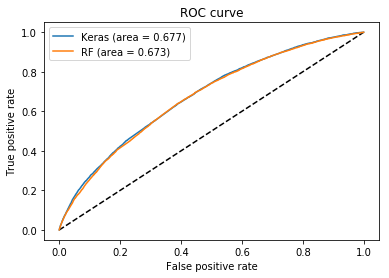

In [590]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



In [594]:
0.673*2-1

0.3460000000000001